In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.decomposition import TruncatedSVD


wordnet_lemmatizer = WordNetLemmatizer()

titles = [line.rstrip() for line in open('all_book_titles.txt')]

# 和情緒分析用一樣的tokenizer
stopwords = set(w.rstrip() for w in open('stopwords.txt'))

# 也可嘗試以nltk處理 stopwords 的方式
# from nltk.corpus import stopwords
# stopwords.words('english')

# 增加處理這問題必要的 stopwords
stopwords = stopwords.union({
    'introduction', 'edition', 'series', 'application',
    'approach', 'card', 'access', 'package', 'plus', 'etext',
    'brief', 'vol', 'fundamental', 'guide', 'essential', 'printed',
    'third', 'second', 'fourth', })

In [2]:
def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, 
                "N": wordnet.NOUN, 
                "V": wordnet.VERB,
                "R": wordnet. ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def my_tokenizer(s):
    s = s.lower() # downcase
    tokens = nltk.tokenize.word_tokenize(s) # 字串變單字 (tokens)
    tokens = [t for t in tokens if len(t) > 3] # 移除短字
    tokens = [wordnet_lemmatizer.lemmatize(t, get_pos(t)) for t in tokens] # 只取英文基本型
    tokens = [t for t in tokens if t not in stopwords] # 移除 stopwords
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)] # 移除數字，比方 "3rd edition"
    return tokens


In [3]:
# 先產生 word-to-index map 再產生 word-frequency vectors
# 同時儲存 tokenized 版本未來不需再做 tokenization
word_index_map = {}
current_index = 0
all_tokens = []
all_titles = []
index_word_map = []
error_count = 0
for title in titles:
    try:
        title = title.encode('ascii', 'ignore').decode('utf-8') # this will throw exception if bad characters
        all_titles.append(title)
        tokens = my_tokenizer(title)
        all_tokens.append(tokens)
        for token in tokens:
            if token not in word_index_map:
                word_index_map[token] = current_index
                current_index += 1
                index_word_map.append(token)
    except Exception as e:
        print(e)
        print(title)
        error_count += 1


print("Number of errors parsing file:", error_count, "number of lines in file:", len(titles))
if error_count == len(titles):
    print("There is no data to do anything with! Quitting...")
    exit()



Number of errors parsing file: 0 number of lines in file: 2373


In [4]:
# 產生輸入矩陣 - 是否出現(indicator)較比例(proportions)更準
def tokens_to_vector(tokens):
    x = np.zeros(len(word_index_map))
    for t in tokens:
        i = word_index_map[t]
        x[i] = 1
    return x

N = len(all_tokens)
D = len(word_index_map)
X = np.zeros((D, N)) # 字彙是列, 文件是行
i = 0
for tokens in all_tokens:
    X[:,i] = tokens_to_vector(tokens)
    i += 1


svd = TruncatedSVD()
Z = svd.fit_transform(X)


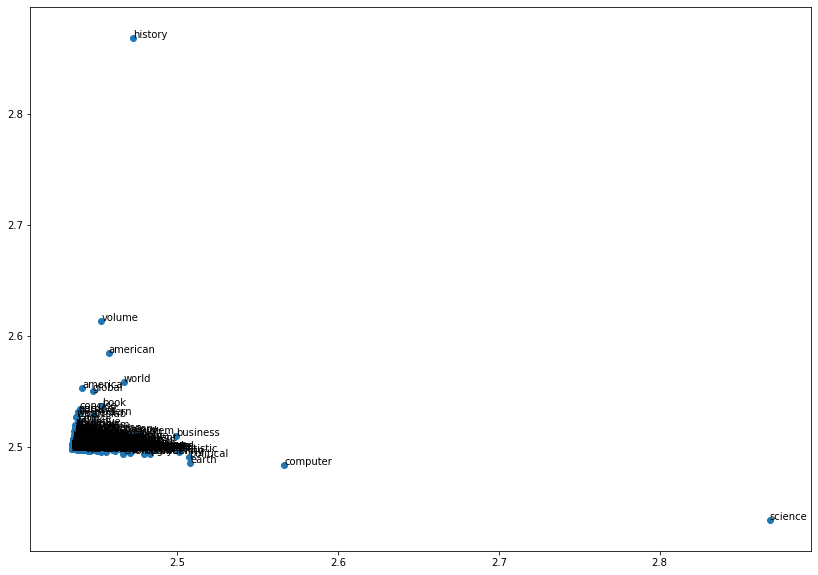

In [5]:
z0_min = np.min(Z[:,0])
z0_max = np.max(Z[:,0])
z0d = z0_max-z0_min
z1_min = np.min(Z[:,1])
z1_max = np.max(Z[:,1])
z1d = z1_max-z1_min

Z0 = np.log10(np.exp((Z[:,0]-z0_min)/z0d+1)*100)
Z1 = np.log10(np.exp((Z[:,1]-z1_min)/z1d+1)*100)

plt.figure(figsize=(14, 10))
plt.scatter(Z0, Z1)
for i in range(D):
    plt.annotate(s=index_word_map[i], xy=(Z0[i], Z1[i]))
plt.show()

In [6]:
X.shape, Z.shape

((1954, 2373), (1954, 2))